In [53]:
# do the necessary imports
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, \
    Flatten, Dense

In [54]:
# load doc into the memory
# open the file as read only
def load_doc(filename):
    file = open(filename, "r")
    text = file.read()
    file.close()
    return text


In [55]:
# load the vocab
vocab_filename = r"vocab.txt"
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())


In [56]:
# preprocess the data and split into train and test sets

negative_file = open('negative.txt', 'r')
all_negative_reviews = negative_file.readlines()

positive_file = open('positive.txt', 'r')
all_positve_reviews = positive_file.readlines()


# lets take 900 neg and 900 pos reviews from dataset for trainset
train_negx = all_negative_reviews[:900]
train_posx = all_positve_reviews[:900]

test_negx = all_negative_reviews[900:]
test_posx = all_positve_reviews[900:]


## below we construct the train and test sets
trainx = np.array(train_negx + train_posx)
trainy = np.array([0 for _ in range(len(train_negx))] +
                  [1 for _ in range(len(train_posx))])

testx = np.array(test_negx + test_posx)
testy = np.array([0 for _ in range(len(test_negx))] +
                  [1 for _ in range(len(test_posx))])

In [57]:
# tokenizer function to fit on texts
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer



In [58]:
max_length = max([len(s.split()) for s in trainx])
print(f"Maximum Length: {max_length}")



Maximum Length: 1319


In [59]:
# integer encode and pad documents
def encode_docs(tokenizer:Tokenizer, max_length, docs):
    #integer encode
    encoded = tokenizer.texts_to_sequences(docs)

    # pad the sequences
    padded = pad_sequences(encoded, max_length, padding='post')

    return padded


In [60]:
# start the training

# create the tokenizer
tokenizer = create_tokenizer(trainx)

# define vocab size
vocab_size = len(tokenizer.word_index) + 1

trainx_padded = encode_docs(tokenizer, max_length, trainx)
testx_padded = encode_docs(tokenizer, max_length, testx)

In [61]:
# create the model

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation="sigmoid"))

# compile the network
model.compile(loss="binary_crossentropy",
              optimizer = 'adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1319, 100)         2689700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1312, 32)          25632     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 656, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20992)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                209930    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 2,925,273
Trainable params: 2,925,273
Non-trainable params: 0
____________________________________________

In [63]:
H = model.fit(trainx_padded, trainy, batch_size=16, epochs=20,
              validation_data=(testx_padded, testy))

Train on 1800 samples, validate on 200 samples
Epoch 1/20
1800/1800 [==============================] - 28s 16ms/sample - loss: 0.6937 - accuracy: 0.4811 - val_loss: 0.6931 - val_accuracy: 0.5000

In [64]:
import pandas as pd
epochs = range(1,20+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

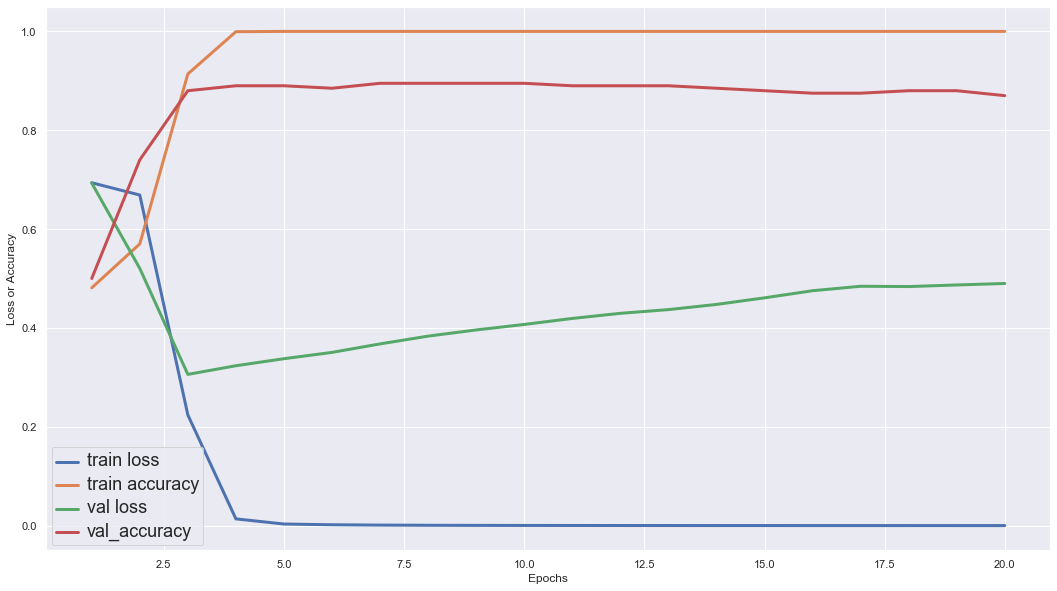

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(18,10))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text